In [1]:
import os
import sys
import csv
import json
import moment
import pymysql
import datetime

import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

%matplotlib inline

# Create a figure of the hazards ratios


In [2]:
intub_results_file = 'results/coxph_intubated_v3-1_2020-04-25.json'
death_results_file = 'results/coxph_died_v3-1_2020-04-25.json'

_version, date_retrieved = intub_results_file.split('_v')[1].split('.')[0].split('_')
_version = 'v' + _version
_version, date_retrieved

('v3-1', '2020-04-25')

## Load the statistical results that we want to also show in the table

In [3]:
coxph_results = {
    'intub': {
        'name': 'Intub HR (95% CI)',
        'results': json.loads(open(intub_results_file).read())
    },
    'death': {
        'name': 'Death HR (95% CI)',
        'results': json.loads(open(death_results_file).read())
    }
}

## This is the main function that will build the rows for a given dataset

Notes:
- `propci` is a function to copute the 95% confidence interval of a proporation
- `build_features` is a function that generates a dictionary of row values

In [4]:
def build_results(all_results, group):
    
    features = defaultdict(dict)
    
    for outcome in all_results.keys():
        
        stat_results = all_results[outcome]['results'][group]
        
        for model in ('univariate', 'age_sex_corrected'):
            hr = stat_results[model]['exp(coef)']
            hrlo = stat_results[model]['exp(coef) lower 95%']
            hrup = stat_results[model]['exp(coef) upper 95%']
            
            loghr = stat_results[model]['coef']
            loghrlo = stat_results[model]['coef lower 95%']
            loghrup = stat_results[model]['coef upper 95%']
            pval = stat_results[model]['p']

            pval_str = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''

            features[outcome][model] = {
                'model': model,
#                 'est': loghr,
#                 'lower': loghr-loghrlo,
#                 'upper': loghrup-loghr
                'est': hr,
                'lower': hr-hrlo,
                'upper': hrup-hr


            }
    
    return features

print(json.dumps(build_results(coxph_results, 'macula'), indent=2))


{
  "intub": {
    "univariate": {
      "model": "univariate",
      "est": 2.171896511807191,
      "lower": 0.8955868846094273,
      "upper": 1.5240204956959778
    },
    "age_sex_corrected": {
      "model": "age_sex_corrected",
      "est": 1.8482448692923723,
      "lower": 0.7674614244976117,
      "upper": 1.3124337229988654
    }
  },
  "death": {
    "univariate": {
      "model": "univariate",
      "est": 3.351123857554164,
      "lower": 1.1638747919366197,
      "upper": 1.783193621510815
    },
    "age_sex_corrected": {
      "model": "age_sex_corrected",
      "est": 1.65290280178907,
      "lower": 0.5760062820785616,
      "upper": 0.884098314062431
    }
  }
}


In [19]:
table_data = {
    'macula': {
        'name': 'Macula',
        'results': build_results(coxph_results, 'macula'),
    },
    'compl_def': {
        'name': 'CD',
        'results': build_results(coxph_results, 'compl_def'),
    },
    'coagulation': {
        'name': 'Coagulation',
        'results': build_results(coxph_results, 'coagulation'),
    },
    'hypertension': {
        'name': 'Hypertension',
        'results': build_results(coxph_results, 'hypertension'),
    },
    'type2_diabetes': {
        'name': 'T2D',
        'results': build_results(coxph_results, 'type2_diabetes'),
    },
    'obesity': {
        'name': 'Obesity',
        'results': build_results(coxph_results, 'obesity'),
    },
    'cad': {
        'name': 'CAD',
        'results': build_results(coxph_results, 'cad'),
    },
    'refctrl': {
        'name': 'Cough',
        'results': build_results(coxph_results, 'refctrl')
    }
}

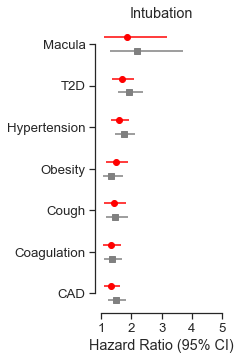

In [25]:
# outcome = 'death'
# outcome_name = 'Mortality'
outcome = 'intub'
outcome_name = 'Intubation'

groups = ['macula', 'coagulation', 'hypertension', 'type2_diabetes', 'obesity', 'cad', 'refctrl']
sorted_groups = sorted([(table_data[covar]['results'][outcome]['age_sex_corrected']['est'], covar) for covar in groups])


uni_estimates = list()
uni_estimate_errors = list()
uni_est_y_positions = list()

asc_estimates = list()
asc_estimate_errors = list()
asc_est_y_positions = list()

names = list()
name_y_positions = list()

y_position = 1

for est, covar in sorted_groups:
    
    d = table_data[covar]['results']
    
    uni = d[outcome]['univariate']
    asc = d[outcome]['age_sex_corrected']
    
    uni_estimates.append(uni['est'])
    uni_estimate_errors.append((uni['lower'], uni['upper']))
    uni_est_y_positions.append(y_position)
    
    asc_estimates.append(asc['est'])
    asc_estimate_errors.append((asc['lower'], asc['upper']))
    asc_est_y_positions.append(y_position + 1)
    
    names.append(table_data[covar]['name'])
    name_y_positions.append(y_position + 0.5)
    
    y_position += 3
    

sns.set(style='ticks', font_scale=1.2)
plt.figure(figsize=(3.5,5))
plt.errorbar(x=uni_estimates, y=uni_est_y_positions, xerr=zip(*uni_estimate_errors), fmt='s', color='grey', alpha=1.0)
plt.errorbar(x=asc_estimates, y=asc_est_y_positions, xerr=zip(*asc_estimate_errors), fmt='o', color='red', alpha=1.0)
plt.xlabel('Hazard Ratio (95% CI)')

#plt.legend(['Univariate', 'Age & Sex Corrected'], loc='upper right',  bbox_to_anchor=(0.5, -0.05))

plt.yticks(name_y_positions, names)
plt.xlim(0.8, 5.2)
plt.xticks([1,2,3,4,5])
plt.tight_layout()
sns.despine(trim=True)

plt.title(outcome_name)
plt.savefig('figures/hazard_ratios_%s_%s_%s.pdf' % (outcome, _version, date_retrieved))
